In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import classification_report,roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('KDDTrain+.txt')
data.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [3]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted'
,'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate'
,'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

data.columns = columns
data = data.drop('level', axis=1)

# remove outliers
data = data.drop(data[data['dst_bytes']>1500].index)
data = data.drop(data[data['src_bytes']>750].index)

data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.0,0.0,neptune
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.0,0.0,0.0,1.0,1.0,neptune
5,0,tcp,private,S0,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.0,1.0,1.0,0.0,0.0,neptune


In [4]:
data.attack.unique()


array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'guess_passwd', 'pod',
       'ftp_write', 'imap', 'warezmaster', 'rootkit', 'land', 'spy',
       'multihop', 'loadmodule', 'buffer_overflow'], dtype=object)

In [5]:
# changing attack labels to their respective attack class
def change_label(df):
  df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [6]:
change_label(data)
data.attack.unique()

array(['normal', 'Dos', 'R2L', 'Probe', 'U2R'], dtype=object)

In [7]:
data.attack.value_counts()

Dos       42773
normal    38357
Probe     11633
R2L         547
U2R          13
Name: attack, dtype: int64

In [8]:
data.isnull().values.any()

False

In [9]:
le = LabelEncoder()

data['protocol_type']=le.fit_transform(data['protocol_type'])
data['service']=le.fit_transform(data['service'])
data['flag']=le.fit_transform(data['flag'])
data['attack']=le.fit_transform(data['attack'])

In [10]:
x = data.drop('attack', axis=1)
y = data['attack']

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x)

In [11]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
y_train = to_categorical(y_train,5)
y_test = to_categorical(y_test,5)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape =(None,1)))

model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.2))

model.add(LSTM(64))

model.add(Dropout(0.2))

model.add(Dense(units=5, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train, epochs=60, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/60
584/584 [==============================] - 19s 27ms/step - loss: 0.3068 - accuracy: 0.8907 - val_loss: 0.0905 - val_accuracy: 0.9695
Epoch 2/60
584/584 [==============================] - 16s 27ms/step - loss: 0.0836 - accuracy: 0.9728 - val_loss: 0.0637 - val_accuracy: 0.9808
Epoch 3/60
584/584 [==============================] - 16s 28ms/step - loss: 0.0628 - accuracy: 0.9799 - val_loss: 0.0483 - val_accuracy: 0.9859
Epoch 4/60
584/584 [==============================] - 17s 29ms/step - loss: 0.0527 - accuracy: 0.9828 - val_loss: 0.0449 - val_accuracy: 0.9861
Epoch 5/60
584/584 [==============================] - 18s 30ms/step - loss: 0.0464 - accuracy: 0.9850 - val_loss: 0.0365 - val_accuracy: 0.9895
Epoch 6/60
584/584 [==============================] - 19s 32ms/step - loss: 0.0386 - accuracy: 0.9881 - val_loss: 0.0325 - val_accuracy: 0.9893
Epoch 7/60
584/584 [==============================] - 19s 32ms/step - loss: 0.0377 - accuracy: 0.9880 - val_loss: 0.0332 - val_accuracy:

584/584 [==============================] - 21s 36ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0099 - val_accuracy: 0.9973
Epoch 58/60
584/584 [==============================] - 21s 36ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0093 - val_accuracy: 0.9976
Epoch 59/60
584/584 [==============================] - 21s 36ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0098 - val_accuracy: 0.9979
Epoch 60/60
584/584 [==============================] - 21s 36ms/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0089 - val_accuracy: 0.9980


In [16]:
# Model Evaluate
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Model Loss: {loss}\nModel Accuracy: {accuracy*100}")

584/584 [==============================] - 4s 7ms/step - loss: 0.0089 - accuracy: 0.9980
Model Loss: 0.008868069387972355
Model Accuracy: 99.801766872406


Text(0, 0.5, 'Loss')

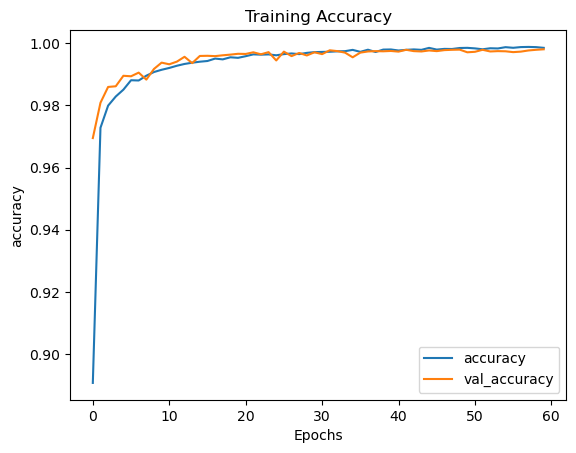

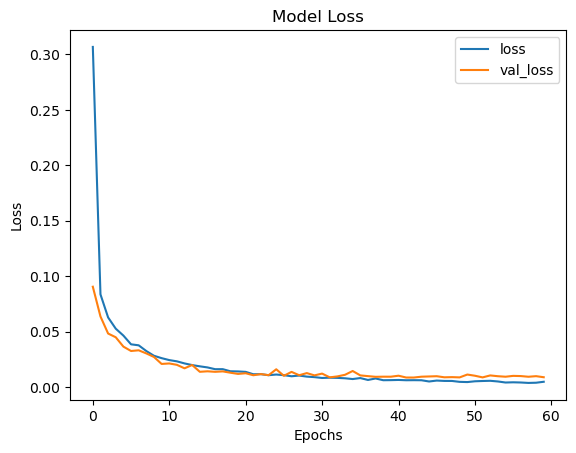

In [17]:
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [18]:
y_predict=model.predict(x_test)

y_pred_classes = y_predict.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)

# classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)

584/584 [==============================] - 4s 6ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8590
           1       1.00      0.99      1.00      2326
           2       0.99      0.96      0.97       115
           3       1.00      0.20      0.33         5
           4       1.00      1.00      1.00      7629

    accuracy                           1.00     18665
   macro avg       1.00      0.83      0.86     18665
weighted avg       1.00      1.00      1.00     18665



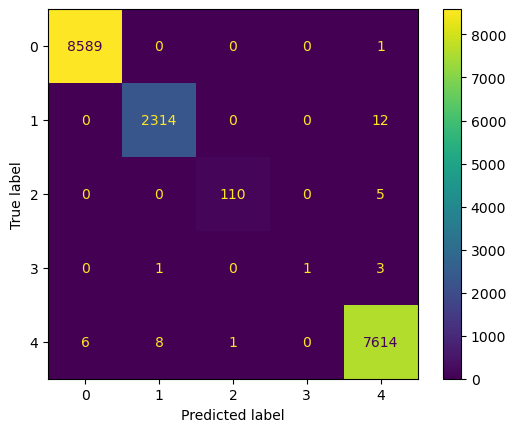

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(cm)

# plot the confusion matrix
cm_display.plot()
plt.show()

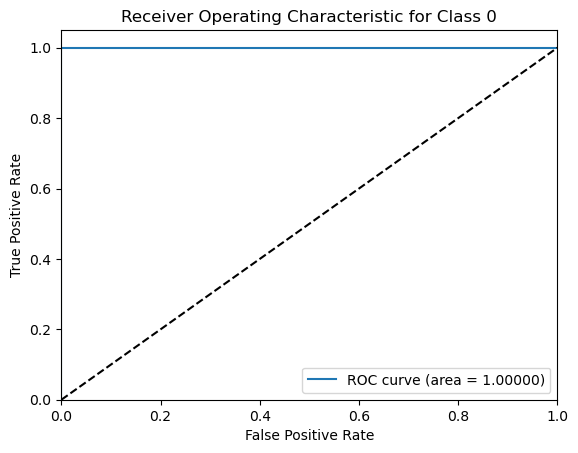

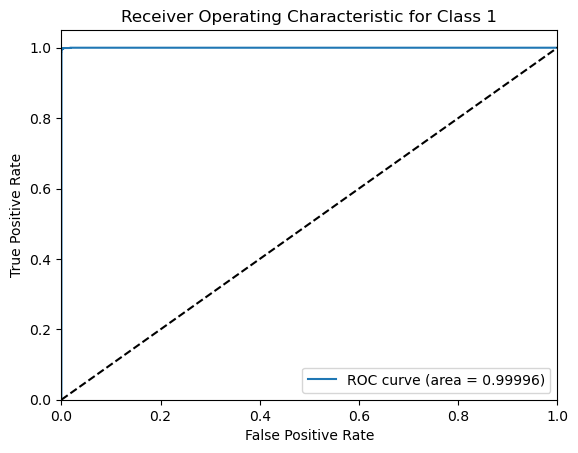

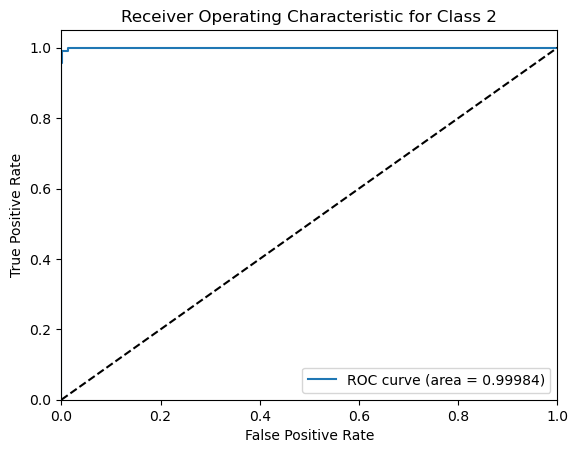

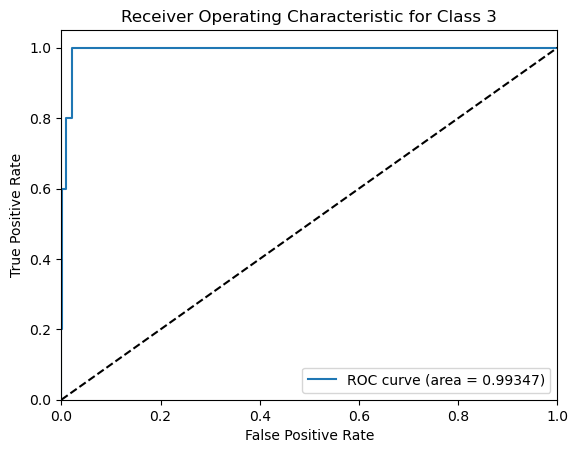

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

n_classes = 4

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_predict[:, i], multi_class='ovr', average='macro')

# Plot ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.5f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Class %d' % i)
    plt.legend(loc="lower right")
    plt.show()

In [25]:
model.save("cnn-lstm_kdd_data.h5")